In [50]:
import numpy as np
import pandas as pd
from fbprophet import Prophet

import matplotlib.pyplot as plt
import seaborn as sb

import os
import sys #only needed to determine the python version number
import matplotlib #only needed to determine Matplotlib version number

# Enable inline plotting (notebook plotting )
%matplotlib inline
print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Matplotlib version ' + matplotlib.__version__)

Python version 3.6.3 (v3.6.3:2c5fed8, Oct  3 2017, 18:11:49) [MSC v.1900 64 bit (AMD64)]
Pandas version 0.20.3
Matplotlib version 2.0.2


Miscellaneous Utility Functions

In [51]:
# Static Utility Functions
def make_prophet_df(y_series):
    num_rows = len(y_series.index)
    c1 = y_series.index
    c2 = y_series.values
    col_data = np.array([c1, c2]).T
    col_names = ['ds', 'y']
    return pd.DataFrame(index=range(num_rows), data=col_data, columns=col_names)

def clip_df(df, start=None, end=None):
    if start is None and end is None:
        return df

    # TODO: Prevent/Avoid invalid input
    if start is None:
        d2 = pd.to_datetime(end)
        return df.loc[(df.index < d2), :]

    if end is None:
        d1 = pd.to_datetime(start)
        return df.loc[(d1 <= df.index), :]

    d1 = pd.to_datetime(start)
    d2 = pd.to_datetime(end)
    indexer = ((d1 <= df.index) & (df.index < d2))
    return df.loc[indexer, :]

def shift_day(today, shift):
    """Shift today by the given number of days."""

    target_day = ''
    # Python 3+ specific code: isinstance(today, str)
    if today and isinstance(today, str):
        try:
            target_day = (pd.to_datetime(today) + pd.DateOffset(days=shift)).strftime('%Y-%m-%d')
        except (TypeError, ValueError):
            # logger.error("Invalid date format encounted.  Try putting the date in this form, '%Y-%m-%d'.")
            pass

    return target_day

Residual Calculation

A function to calculate the difference between the actual data (df_data) and the forecast (df_base).

In [52]:
def calculate_residual_dataframe(df_data, df_base):
    """A function to calculate the Prophet Forecast Errors = Data - Forecast
    :param df_data: DataFrame with Integer indices, and columns ds and y
    :param df_base: DataFrame with datetime indices, and column yhat
    :return: DataFrame with datetime indices, and column residual = y - yhat"""

    print("Entered calculate_residual_dataframe")
    if df_data is None or df_base is None:
        print("Input None?")
        # logger.error("A dataframe input to calculate_residual_dataframe is invalid")
        return None

    if not isinstance(df_data, pd.DataFrame):
        print("df_data: Not a dataframe?")
        # logger.error("The dataframe input to calculate_residual_dataframe is invalid")
        return None

    if not isinstance(df_base, pd.DataFrame):
        print("df_base: Not a dataframe?")
        # logger.error("The dataframe input to calculate_residual_dataframe is invalid")
        return None

    if df_data.empty or df_base.empty:
        print("Empty dataframe?")
        # logger.error("Empty dataframe passed into calculate_residual_dataframe")
        return None

    # Prophet requires the datetime column to be named 'ds'.
    if not 'ds' in df_data.columns.values:
        print("ds no in df_data?")
        # logger.warn("Expected column ds in the data.  Skipping residual calculation.")
        return None
    
    # Prophet requires the data column to be named 'y'.
    if not 'y' in df_data.columns.values:
        print("y not in df_data?")
        # logger.warn("Expected column y in the data.  Skipping residual calculation.")
        return None

    # Prophet names the predicted data column 'yhat'.
    if not 'yhat' in df_base.columns.values:
        print("yhat not in df_base?")
        # logger.warn("Expected column yhat in the prediction.  Skipping residual calculation.")
        return None

    df = df_data.set_index('ds')
    y = df.loc[df.index.isin(df_base.index), 'y']
    yhat = df_base.loc[df_base.index.isin(df.index), 'yhat']
    residual = y.subtract(yhat, fill_value=0)

    return residual.to_frame().rename(columns={0:'Residual'})

In [53]:
data_file = "C:/Prophet/data_sets/modified_per15minute_data_AP1_Incoming.csv"
df = pd.read_csv(data_file, index_col=0, parse_dates=['ds'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11519 entries, 0 to 11518
Data columns (total 2 columns):
ds    11519 non-null datetime64[ns]
y     11519 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 270.0 KB


In [54]:
y_values = df.set_index('ds').loc[:,'y']

In [55]:
df_data = make_prophet_df(y_values)

Modeling Holidays and Special Events

If you have holidays or other recurring events that you'd like to model, you must create a dataframe for them. It has two columns (holiday and ds) and a row for each occurrence of the holiday. It must include all occurrences of the holiday, both in the past (back as far as the historical data go) and in the future (out as far as the forecast is being made). If they won't repeat in the future, Prophet will model them and then not include them in the forecast.

You can also include columns lower_window and upper_window which extend the holiday out to [lower_window, upper_window] days around the date. For instance, if you wanted to included Christmas Eve in addition to Christmas you'd include lower_window=-1,upper_window=0. If you wanted to use Black Friday in addition to Thanksgiving, you'd include lower_window=0,upper_window=1. You can also include a column prior_scale to set the prior scale separately for each holiday.

Prior scale for holidays and seasonality

If you find that the holidays are overfitting, you can adjust their prior scale to smooth them using the parameter holidays_prior_scale. By default this parameter is 10, which provides very little regularization. Reducing this parameter dampens holiday effects:

In [56]:
# Add holidays, plus July 3rd ....
holiday_dates = ['2017-05-29', '2017-07-04', '2017-09-04']
us_holidays = pd.DataFrame({'holiday': 'us_holidays',
                            'ds': pd.to_datetime(holiday_dates),
                           'lower_window': [0, -1, 0], 'upper_window': 0})
holidays = us_holidays
holidays

# # Include the days off as holidays.
# # This will be all weekends and holidays....
# saturdays = pd.DataFrame({'holiday': 'saturday', 'ds': pd.date_range(start='2017-05-06', end='2017-09-07', freq='7D')})
# sundays = pd.DataFrame({'holiday': 'sunday', 'ds': pd.date_range(start='2017-05-06', end='2017-09-07', freq='7D')})
# us_holidays = pd.DataFrame({'holiday': 'us_holidays',
#                             'ds': pd.to_datetime(['2017-05-29', '2017-07-03', '2017-07-04', '2017-09-04'])})
# holidays = pd.concat((saturdays, sundays, us_holidays))
# holidays

,ds,holiday,lower_window,upper_window
0,2017-05-29,us_holidays,0,0
1,2017-07-04,us_holidays,-1,0
2,2017-09-04,us_holidays,0,0


Instantiate the Prophet object

In [57]:
m1 = Prophet(yearly_seasonality=False, holidays=holidays)
# m1 = Prophet(yearly_seasonality=False, holidays=holidays, holidays_prior_scale=0.1)
# m1 = Prophet(yearly_seasonality=False, holidays=holidays, holidays_prior_scale=25)

Fit the Model

In [58]:
m1.fit(df_data)

Create Future DataFrames for the Predict Function

In [59]:
df_future1 = m1.make_future_dataframe(periods=7*24*4, freq='15T')
df_future2 = m1.make_future_dataframe(periods=2*7*24*4, freq='15T')
# df_future4 = m1.make_future_dataframe(periods=4*7*24*4, freq='15T')

Calculate the Forecast 2 weeks out.

In [60]:
df_forecast2 = m1.predict(df_future2)
df_forecast2.tail()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,daily,daily_lower,daily_upper,holidays,...,seasonalities,seasonalities_lower,seasonalities_upper,us_holidays,us_holidays_lower,us_holidays_upper,weekly,weekly_lower,weekly_upper,yhat
12858,2017-09-12 22:45:00,27898.792554,26903.503892,28798.170399,6457.399973,37023.439974,-10356.216799,-10356.216799,-10356.216799,0.0,...,-6218.912142,-6218.912142,-6218.912142,0.0,0.0,0.0,4137.304657,4137.304657,4137.304657,21679.880411
12859,2017-09-12 23:00:00,27900.750603,26903.590674,28801.291093,6718.293902,36725.814890,-10347.733970,-10347.733970,-10347.733970,0.0,...,-6212.404770,-6212.404770,-6212.404770,0.0,0.0,0.0,4135.329200,4135.329200,4135.329200,21688.345833
12860,2017-09-12 23:15:00,27902.708652,26904.041335,28804.411786,5607.548320,37381.668296,-10321.754777,-10321.754777,-10321.754777,0.0,...,-6187.816152,-6187.816152,-6187.816152,0.0,0.0,0.0,4133.938625,4133.938625,4133.938625,21714.892500
12861,2017-09-12 23:30:00,27904.666701,26904.491996,28807.740340,5830.502174,37777.441520,-10283.614790,-10283.614790,-10283.614790,0.0,...,-6150.485471,-6150.485471,-6150.485471,0.0,0.0,0.0,4133.129320,4133.129320,4133.129320,21754.181231
12862,2017-09-12 23:45:00,27906.624750,26905.017683,28811.331413,5652.265859,37059.979710,-10237.138169,-10237.138169,-10237.138169,0.0,...,-6104.241078,-6104.241078,-6104.241078,0.0,0.0,0.0,4132.897091,4132.897091,4132.897091,21802.383672


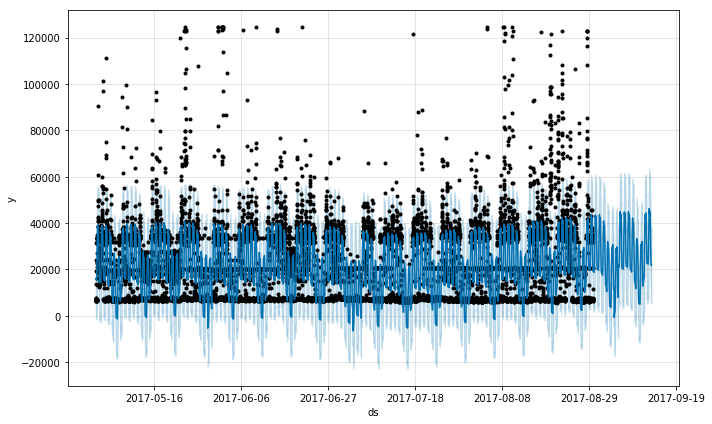

In [61]:
m1.plot(df_forecast2);

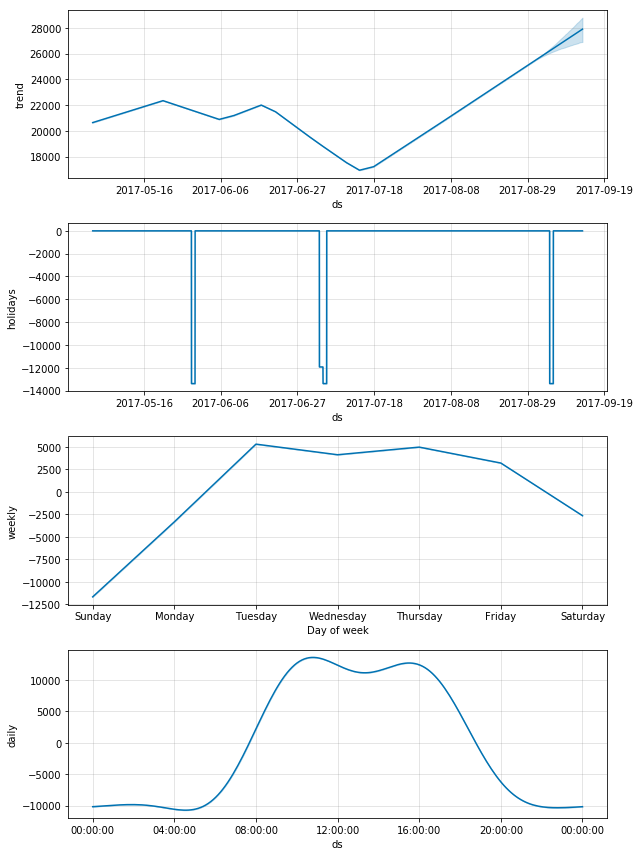

In [62]:
m1.plot_components(df_forecast2);

Side Note: Attempting to restrict the forecast region by restricting the forecast dataframe does not work, because the model still has the full range of data.

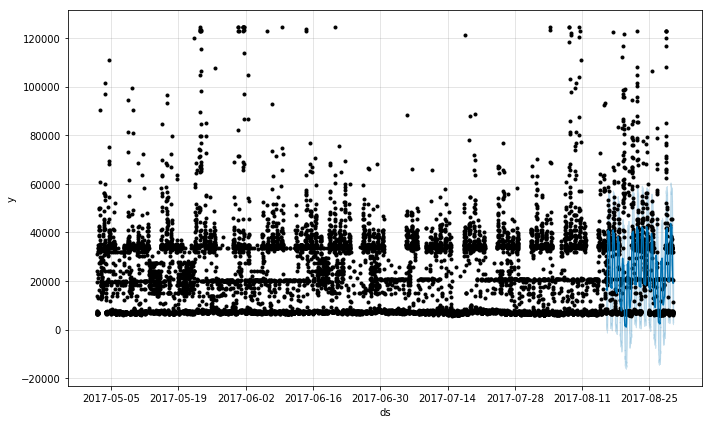

In [63]:
index1 = df_forecast2[df_forecast2['ds'] == '2017-08-16'].index[0]
index2 = df_forecast2[df_forecast2['ds'] == '2017-08-30'].index[0] - 1

m1.plot(df_forecast2.iloc[index1:index2, :]);

In [64]:
d1 = shift_day('2017-08-30', -14)
d2 = shift_day('2017-08-30', -7)
d3 = '2017-08-29'
d4 = shift_day(d2, 14)
yhat = df_forecast2.set_index('ds').loc[d1:d4, ['yhat']]

In [65]:
df_predictions = yhat.join(y_values[d1:d3].to_frame())
print(df_predictions.head())
print(df_predictions.tail())

                             yhat        y
ds                                        
2017-08-16 00:00:00  16593.532997   6957.0
2017-08-16 00:15:00  16652.004202  33022.0
2017-08-16 00:30:00  16712.640512   7065.0
2017-08-16 00:45:00  16773.302188  21252.0
2017-08-16 01:00:00  16831.344777   7888.0
                             yhat   y
ds                                   
2017-09-06 22:45:00  21402.293283 NaN
2017-09-06 23:00:00  21412.506902 NaN
2017-09-06 23:15:00  21439.739567 NaN
2017-09-06 23:30:00  21478.654908 NaN
2017-09-06 23:45:00  21525.428335 NaN


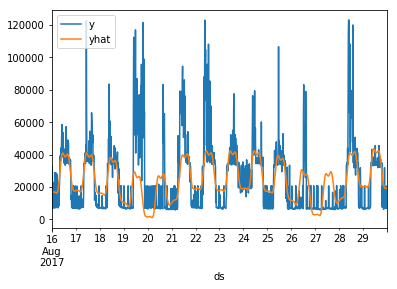

In [66]:
df_predictions.loc[d1:d3, ['y', 'yhat']].plot()

In [67]:
print(type(df_data['ds'][0]))

<class 'pandas._libs.tslib.Timestamp'>


Entered calculate_residual_dataframe


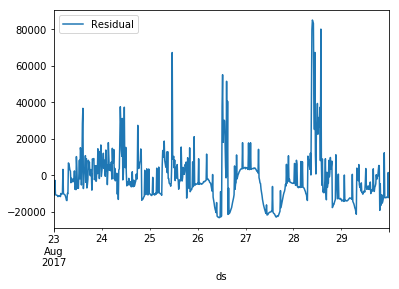

In [68]:
df_prophet_residual = calculate_residual_dataframe(df_data, df_forecast2.set_index('ds'))

predicted_data_start = pd.to_datetime('2017-08-23')
predicted_data_end = pd.to_datetime('2017-08-30')
clip_df(df_prophet_residual, '2017-08-23', '2017-08-30').plot()

In [69]:
def rms_error(residuals):
    return np.sqrt(np.mean(residuals**2))

def mean_abs_error(residuals):
    return np.mean(np.abs(residuals))

prophet_residuals = df_prophet_residual.loc[d2:d3, 'Residual'].get_values()
prophet_rmse = rms_error(prophet_residuals)
prophet_mae = mean_abs_error(prophet_residuals)

In [70]:
print("Prophet MAE = {}".format(prophet_mae))

Prophet MAE = 10148.65129823681


In [71]:
print("Prophet RMSE = {}".format(prophet_rmse))

Prophet RMSE = 14477.375832525175
